# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
# Add your imports here
import pandas as pd
import math
import numpy as np
import matplotlib 
import json
import zipfile
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [3]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

In [4]:
# Write your code here
colors = pd.read_csv(LEGO_DATA_FOLDER+'/colors.csv.zip', compression='zip', sep=',')
inventories = pd.read_csv(LEGO_DATA_FOLDER+'/inventories.csv.zip', compression='zip', sep=',')
inventory_parts = pd.read_csv(LEGO_DATA_FOLDER+'/inventory_parts.csv.zip', compression='zip', sep=',')
inventory_sets = pd.read_csv(LEGO_DATA_FOLDER+'/inventory_sets.csv.zip', compression='zip', sep=',')
part_categories = pd.read_csv(LEGO_DATA_FOLDER+'/part_categories.csv.zip', compression='zip', sep=',')
parts = pd.read_csv(LEGO_DATA_FOLDER+'/parts.csv.zip', compression='zip', sep=',')
sets = pd.read_csv(LEGO_DATA_FOLDER+'/sets.csv.zip', compression='zip', sep=',')
themes = pd.read_csv(LEGO_DATA_FOLDER+'/themes.csv.zip', compression='zip', sep=',')

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

###  range of the sets

In [5]:
'''
First we parsed the year values to numerical values, then we ignored the NaN values to be able to find the range 
of the sets.
In order to preserve our intial data we started by creating a copy of it into dataFrame that we called sets_range.
When parsing our values we have set the errors='coerce' to prevent deleting all the rows with NaN values. 
We also puted the downcast='float' and no to integer beacause the executor interpret NaN values as float.
'''
sets_range = sets.copy()
sets_range.year = pd.to_numeric(sets_range['year'],errors='coerce',downcast='float')
#sets_range_ = sets_range[~sets_range.year.isna()]

In [6]:
'''
We can see that the range is too big which implie that our data contain very distant values.
'''
sets_range.year.max()-sets_range.year.min()

40343.0

In [7]:
''' 
In order to conserve a maximum amout of data we first started by observing and studying negative values
So that we concluded that some of them seems to be correct if we take their absolute values.
'''
sets_range.year = sets_range.year.abs()

In [8]:
'''
At this stage, we observed that in some year entries where the size in integer is 5 digits the last 2 digits are
the same so we concluded that this a typo so we did the following step to delete the last digit.
We ignored values such 70s beacause they do represent roughly 1% of our data and we can either transform them
to 1970 or choose the most frequent year in the 70s but we cannot be sur that the value we are going to give
is correct so we decided to ignore them.
'''
sets_range.year=sets_range.year.apply(lambda year: math.floor(year/10) if 
                                      len(str(year))==7 and str(year)[3]==str(year)[4] else year)

In [9]:
'''
At this step we can check that the range seems to be reasonable
'''
sets_range.year.max()-sets_range.year.min()

67.0

### Average quantity

In [10]:
'''
The inventory parts quantity is equal to infinite which mean that it contains infinite values.
'''
inventory_parts.quantity.mean()

-inf

In [11]:
'''
we copy our data to presrve the intial data, and we replaced the inf values with the nan values so that we wont
delete all the row and lose infomration.
'''
inventory_parts_cleaned=inventory_parts.copy()
inventory_parts_cleaned.quantity=inventory_parts_cleaned.quantity.replace(-np.inf,np.nan )

In [12]:
'''
As you can see the mean seem to be more reasonable.
'''
inventory_parts_cleaned.quantity.mean()

3.836938260983857

__\* Briefly explain your approach here \*__

### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. What do you observe for the years 1980-1981? How do you interpret what you see?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

In [13]:
#Fisrt question:
'''
To obtain all the variations of cars we first started by selecting sentences that endswith Car and car, 
Also sentences that contain car in the middle so we added spaces before and after, The third one 
is select sentences where car is in the first position, and the last line is for plural. 
'''
cars = sets_range[sets_range['name'].str.endswith('Car')| sets_range['name'].str.endswith('car')|
                  sets_range['name'].str.contains(' car ')| sets_range['name'].str.contains(' Car ')|
                  sets_range['name'].str.contains('car ')| sets_range['name'].str.contains('Car ')|
                  sets_range['name'].str.contains('Cars')|sets_range['name'].str.contains('cars')]

In [14]:
cars.head()

,id,name,year,theme_id,num_parts
27,10002-1,Railroad Club Car,2001.0,233,272
50,10022-1,"Santa Fe Cars - Set II (dining, observation, o...",2002.0,237,410
53,10025-1,Santa Fe Cars - Set I (mail or baggage car),2002.0,237,325
142,10158-1,High Speed Train Car,2004.0,239,151
154,10170-1,TTX Intermodal Double-Stack Car,2005.0,236,365


In [15]:
#Second question
'''
We first merged the car dataFrame above with the inventory_sets dataFrame in order to keep only indexes that 
we need and this is  why we have set how='inner'.
After that we took the resulting dataFrame and we counted the values using part_cat_id as index to count 
the number of parts that belongs to a certain category as it's already sorted by the method we transforme 
it to a dataframe and set the index to plot the barchart with the right axis.
'''
inventory_cars_id=pd.DataFrame.merge(cars,inventory_sets,how='inner', 
                                     left_on=cars.id,right_on=inventory_sets.set_id)[['id']]

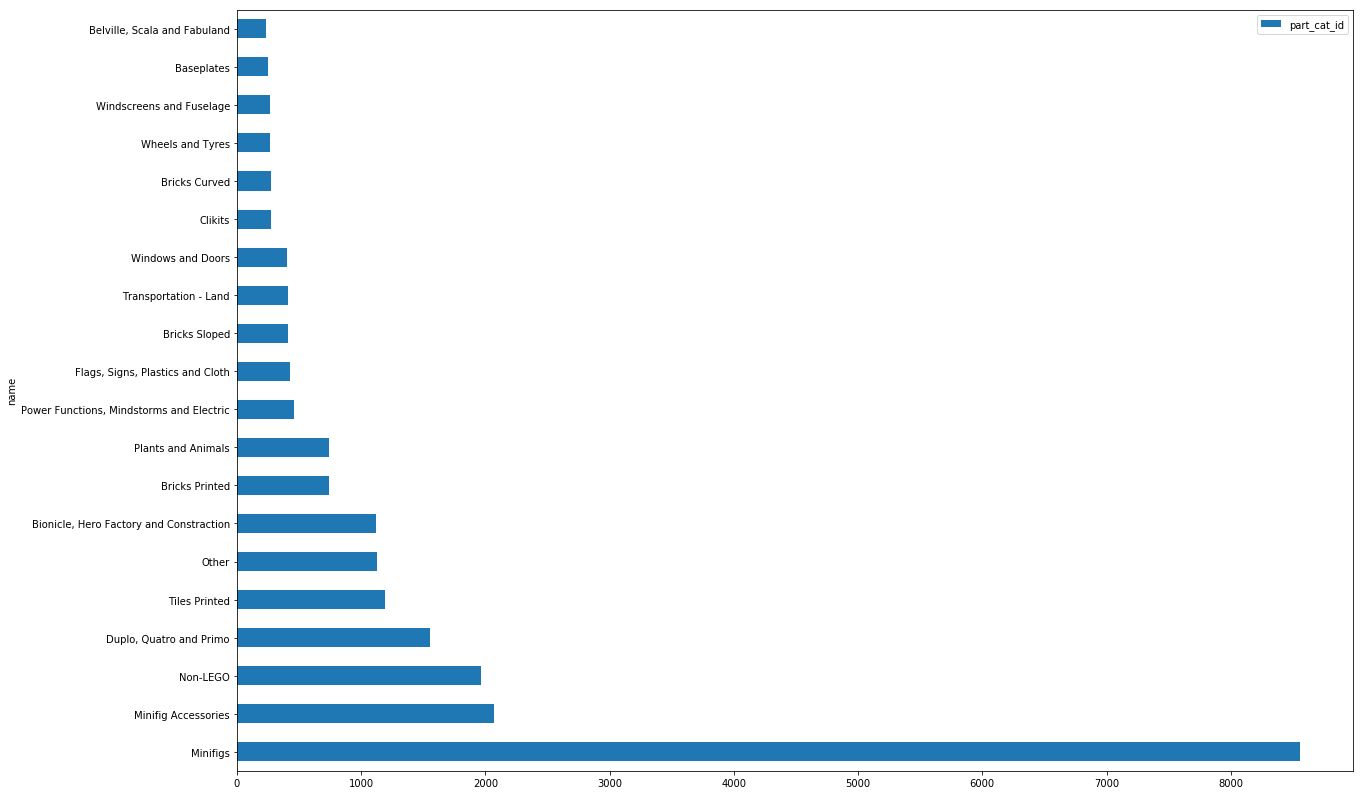

In [16]:
part_per_category=parts.part_cat_id.value_counts().head(20).to_frame()
#we did the following merge in order to have names at the axis plot instead pf category ids.
count_with_names=pd.merge(part_per_category,part_categories,how='left', left_on=part_per_category.index, \
            right_on = part_categories.id)[['part_cat_id','name']]

count_with_names.set_index('name',inplace=True)
count_with_names.plot.barh(figsize=(20,14))

In [17]:
#Third questions
'''
To answer the third questions we have done multiplte merges in order to have the set_ID and the rgb color in 
the same dataframe so that we can do the plot.
So we merged the inventory_sets with the sets_range and after that with the inventory parts and one more time
with colors. 
At every step we keep only columns that we are interrested in to minimize the computation. 
'''
inventory_merge_sets = pd.merge(inventory_sets,sets_range,how = 'inner', left_on = inventory_sets.set_id,
                                   right_on = sets_range.id)[['inventory_id','set_id']]

inventory_merge_sets_merge_parts = pd.merge(inventory_merge_sets,inventory_parts,how = 'inner', 
                                          left_on = inventory_merge_sets.inventory_id,
                                   right_on = inventory_parts.inventory_id)[['set_id','color_id']]

inventory_merge_sets_merge_parts = inventory_merge_sets_merge_parts.groupby(['set_id','color_id']).size() \
                            .groupby(level = 0).idxmax().apply(lambda x: x[1]).reset_index(name = 'color_id')

sets_colors = pd.merge(inventory_merge_sets_merge_parts,colors,how = 'inner', 
                                          left_on = inventory_merge_sets_merge_parts.color_id,
                                   right_on = colors.id)[['set_id','name','rgb']]

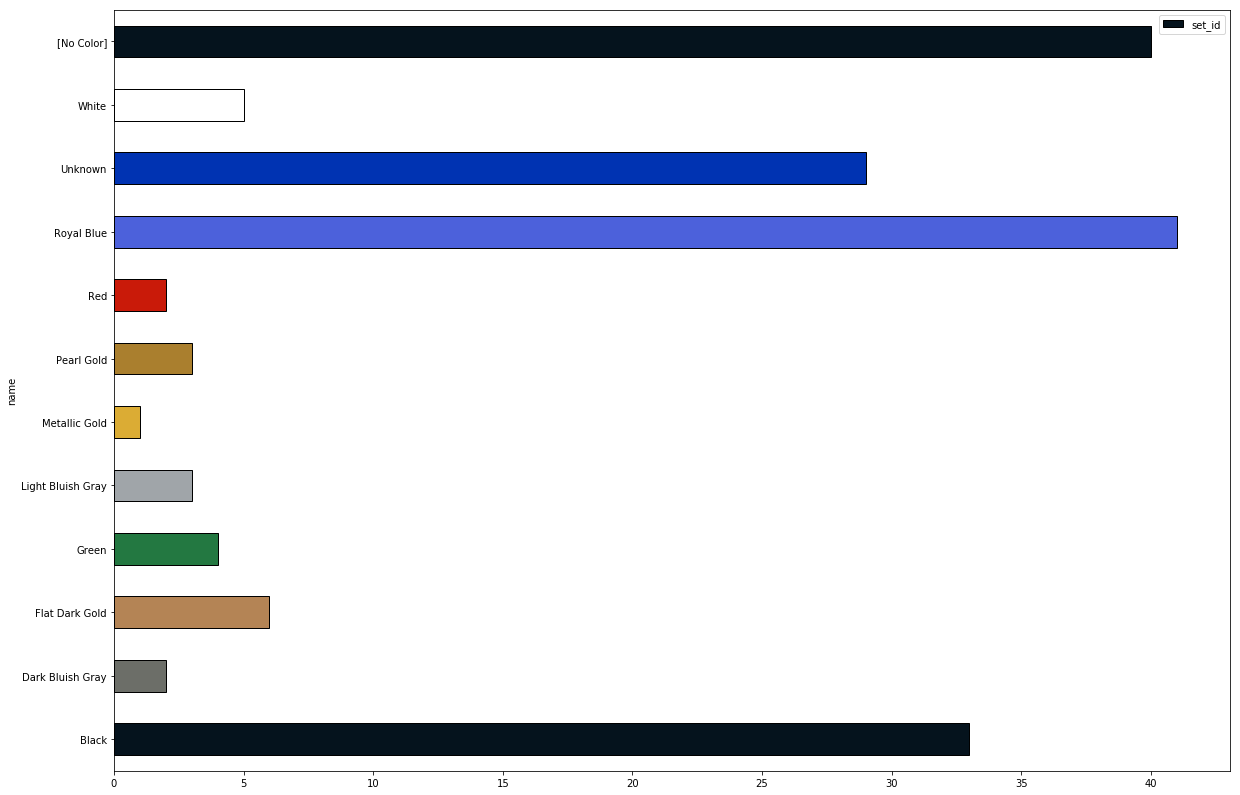

In [18]:
'''
At this step we have done the count of the colors and have changed the index to name to have them on the plot.
we used as arguments for colors in the plot the rgb that we were given in the dataset.
'''
sets_colors_plot = sets_colors.groupby(['name','rgb'])['set_id'].count().reset_index().set_index('name')
sets_colors_plot.plot.barh(figsize = (20,14),color = [str("#") + sets_colors_plot.rgb], edgecolor='black')


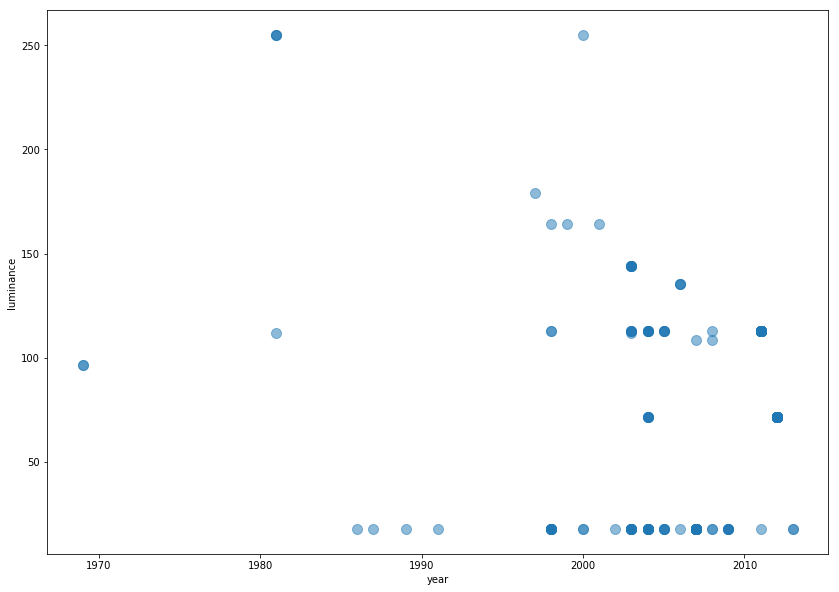

In [19]:
'''
We applied the lumiance function to our rgb column after extracting the hexadecimal values.
To have the year we have done the merge with the sets_range. Again we only keep the minimal number of columns.
'''
sets_colors.rgb=sets_colors.rgb.apply(lambda hx: (int(hx[0:2],16),int(hx[2:4],16),int(hx[4:6],16)))
sets_colors['luminance'] = sets_colors['rgb'].apply(
                                lambda x: math.sqrt(0.299*x[0]*x[0]+0.587*x[1]*x[1]+0.114*x[2]*x[2] ))

luminance_per_year=pd.merge(sets_colors[['set_id','luminance']],sets_range[['id','year']],how='inner',left_on
                 =sets_colors.set_id,right_on=sets.id)[['year','luminance']]

luminance_per_year.plot.scatter(x='year',y='luminance',figsize=(14,10),s=100,alpha=0.5)

Between the year 1980 and 1981 we can see that the lumiance has experienced one of it's important 
variation. We can see from the plot that it's even the maximum of lumiance all over the years.
To learn more about the problem we have done some google researches and we found this usefull link
http://brickarchitect.com/color/ where the explained this peak by the addition of new colors.

## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [20]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [21]:
zipped_bikes = zipfile.ZipFile(BIKES_DATA_FOLDER +'/metro-bike-share-trip-data.json.zip')
bikes = pd.DataFrame(json.loads(zipped_bikes.read(zipped_bikes.infolist()[0]).decode()))
bikes.head()

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,6281.0,180,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07T04:17:00,3014.0,34.056610,-118.23721,1912818,Round Trip
1,6281.0,1980,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07T06:00:00,3014.0,34.056610,-118.23721,1919661,Round Trip
2,5861.0,300,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,Flex Pass,365.0,2016-07-07T10:32:00,3016.0,34.052898,-118.24156,1933383,Round Trip
3,5861.0,10860,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,Flex Pass,365.0,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,1944197,Round Trip
4,6674.0,420,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,Walk-up,0.0,2016-07-07T12:51:00,3032.0,34.049889,-118.25588,1940317,Round Trip


### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

In [22]:
'''
With the info methode we can see the type of the attributes and how many of them are non null.
The attributes are either float64, int64 or object. 
Bike ID, Ending Station ID, Plan Duration, Starting station ID : Are considered as float64 beacause their rows 
contain missing informations and pd have put NaN in them so they are converted to float64 instead of being integer
like Duration and Trip ID.
End Time and Start Time are considered as objects
Passholder Type, Plan Duration and Trip Route Category are also considered as object, later we will convert them 
to Categorical objects.
'''
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 14 columns):
Bike ID                       132417 non-null float64
Duration                      132427 non-null int64
End Time                      132427 non-null object
Ending Station ID             132331 non-null float64
Ending Station Latitude       131376 non-null float64
Ending Station Longitude      131376 non-null float64
Passholder Type               132427 non-null object
Plan Duration                 131661 non-null float64
Start Time                    132427 non-null object
Starting Station ID           132408 non-null float64
Starting Station Latitude     132379 non-null float64
Starting Station Longitude    132379 non-null float64
Trip ID                       132427 non-null int64
Trip Route Category           132427 non-null object
dtypes: float64(8), int64(2), object(4)
memory usage: 14.1+ MB


In [23]:
'''
With the describe function we can observe the max and the min of each attribute from which we can easely find 
the range.
Describe will only give us the values for attributes of type float64 or int64 but not the others.
'''
describe=bikes.describe(include='all').loc[['max','min']]
describe.loc['range']= (describe.loc['max']-describe.loc['min'])
describe

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
max,6728.0,86400.0,NaN,4108.0,34.064281,0.000000,NaN,365.0,NaN,4108.0,34.064281,0.000000,23794218.0,NaN
min,1349.0,60.0,NaN,3000.0,0.000000,-118.472832,NaN,0.0,NaN,3000.0,0.000000,-118.472832,1912818.0,NaN
range,5379.0,86340.0,NaN,1108.0,34.064281,118.472832,NaN,365.0,NaN,1108.0,34.064281,118.472832,21881400.0,NaN


In [24]:
'''
In Order to calculate the value range of the other variables we need to proceed according to each attribute type.
Remaining attributes: End Time, Start Time, Plan Duration, Passholder Type, Trip Route Category. 
The attributes that are categorical : Plan Duration, Passholder Type, Trip Route Category.
'''

'\nIn Order to calculate the value range of the other variables we need to proceed according to each attribute type.\nRemaining attributes: End Time, Start Time, Plan Duration, Passholder Type, Trip Route Category. \nThe attributes that are categorical : Plan Duration, Passholder Type, Trip Route Category.\n'

In [25]:
'''
As you can see below the type of Start time and End time are String. 
So we are going to transform them into datetime in order to extract the range.
'''
type(bikes['Start Time'][0])

str

In [26]:
bikes['Start Time'] = pd.to_datetime(bikes['Start Time'], format = '%Y-%m-%dT%H:%M:%S')
bikes['End Time'] = pd.to_datetime(bikes['End Time'], format = '%Y-%m-%dT%H:%M:%S')

In [27]:
print("The range of End Time is: " + str(max(bikes['End Time'])-min(bikes['End Time'])) + "\n"
      "The rane of Start Time is: " + str(max(bikes['Start Time'])-min(bikes['Start Time'])))

The range of End Time is: 269 days 06:12:00
The rane of Start Time is: 267 days 19:28:00


In [28]:
###Indicate and transform the attributes that are Categorical
bikes["Plan Duration"] = bikes["Plan Duration"].astype('category')
bikes["Trip Route Category"] = bikes["Trip Route Category"].astype('category')
bikes["Passholder Type"] = bikes["Passholder Type"].astype('category')

# Answering the first question.
The redudant columns are duration and start time and end time: We can only keep 2 of them to have all the 
informations we need.
For the station longitude and latitude we can see that it depends only on the station so we can have new dataframe with station ID and their longitude and latitude and keep station ID only in the bikes dataframe.
Also we can see that we can deduce the passholder type from or the plan duration so we will keep only one of them and have only one column in the initial dataframe.


In [29]:
'''
I am going to drop the column End Time, with Start Time and Duration I can know the End Time
'''
bikes_non_redundant=bikes.copy()
bikes_non_redundant=bikes_non_redundant.drop(labels='End Time', axis=1)

In [30]:
passholder_planDuration = pd.DataFrame(bikes_non_redundant,columns=['Passholder Type','Plan Duration'])
passholder_planDuration = passholder_planDuration.drop_duplicates()
passholder_planDuration.head()

,Passholder Type,Plan Duration
0,Monthly Pass,30.0
2,Flex Pass,365.0
4,Walk-up,0.0
55790,Staff Annual,NaN
98675,Monthly Pass,NaN


In [31]:
station_ID_long_lattitude = pd.DataFrame(bikes,columns=['Starting Station ID','Starting Station Latitude'
                                                                   ,'Starting Station Longitude'])
station_ID_long_lattitude=station_ID_long_lattitude.drop_duplicates()
station_ID_long_lattitude.head()

,Starting Station ID,Starting Station Latitude,Starting Station Longitude
0,3014.0,34.056610,-118.23721
2,3016.0,34.052898,-118.24156
4,3032.0,34.049889,-118.25588
5,3021.0,34.045609,-118.23703
6,3022.0,34.046070,-118.23309


In [32]:
bikes_non_redundant=bikes_non_redundant.drop(labels=['Starting Station Latitude','Ending Station Latitude',
                                                    'Starting Station Longitude','Ending Station Longitude']\
                                             , axis=1)
bikes_non_redundant.head()

,Bike ID,Duration,Ending Station ID,Passholder Type,Plan Duration,Start Time,Starting Station ID,Trip ID,Trip Route Category
0,6281.0,180,3014.0,Monthly Pass,30.0,2016-07-07 04:17:00,3014.0,1912818,Round Trip
1,6281.0,1980,3014.0,Monthly Pass,30.0,2016-07-07 06:00:00,3014.0,1919661,Round Trip
2,5861.0,300,3016.0,Flex Pass,365.0,2016-07-07 10:32:00,3016.0,1933383,Round Trip
3,5861.0,10860,3016.0,Flex Pass,365.0,2016-07-07 10:37:00,3016.0,1944197,Round Trip
4,6674.0,420,3032.0,Walk-up,0.0,2016-07-07 12:51:00,3032.0,1940317,Round Trip


In [33]:
'''
From the description of the data the passholder type = Staff Annual is removed but in the plot in question
4 we can see that there is a trace of them, so we will remove them
'''
bikes_non_redundant=bikes_non_redundant[~(bikes_non_redundant['Passholder Type']=='Staff Annual')]

In [34]:
bikes_non_redundant.head()

,Bike ID,Duration,Ending Station ID,Passholder Type,Plan Duration,Start Time,Starting Station ID,Trip ID,Trip Route Category
0,6281.0,180,3014.0,Monthly Pass,30.0,2016-07-07 04:17:00,3014.0,1912818,Round Trip
1,6281.0,1980,3014.0,Monthly Pass,30.0,2016-07-07 06:00:00,3014.0,1919661,Round Trip
2,5861.0,300,3016.0,Flex Pass,365.0,2016-07-07 10:32:00,3016.0,1933383,Round Trip
3,5861.0,10860,3016.0,Flex Pass,365.0,2016-07-07 10:37:00,3016.0,1944197,Round Trip
4,6674.0,420,3032.0,Walk-up,0.0,2016-07-07 12:51:00,3032.0,1940317,Round Trip


In [35]:
'''
To answer the questions of inconsistencies, the more columns we have the more inconsistencies we can get because
we have more probabilty of loosing data entires. 
So the cleaned data is more consistent than the intial data.
'''
print('The type of attributes and shapes : \n' + str(bikes_non_redundant.dtypes) + str (bikes_non_redundant.shape)+'\n')
print('The type of attributes and shapes : \n' + str(passholder_planDuration.dtypes) + str (passholder_planDuration.shape) +'\n')
print('The type of attributes and shapes : \n' + str(station_ID_long_lattitude.dtypes) + str (station_ID_long_lattitude.shape))

The type of attributes and shapes : 
Bike ID                       float64
Duration                        int64
Ending Station ID             float64
Passholder Type              category
Plan Duration                category
Start Time             datetime64[ns]
Starting Station ID           float64
Trip ID                         int64
Trip Route Category          category
dtype: object(132045, 9)

The type of attributes and shapes : 
Passholder Type    category
Plan Duration      category
dtype: object(5, 2)

The type of attributes and shapes : 
Starting Station ID           float64
Starting Station Latitude     float64
Starting Station Longitude    float64
dtype: object(129, 3)


### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f65349f7f60>]],
      dtype=object)

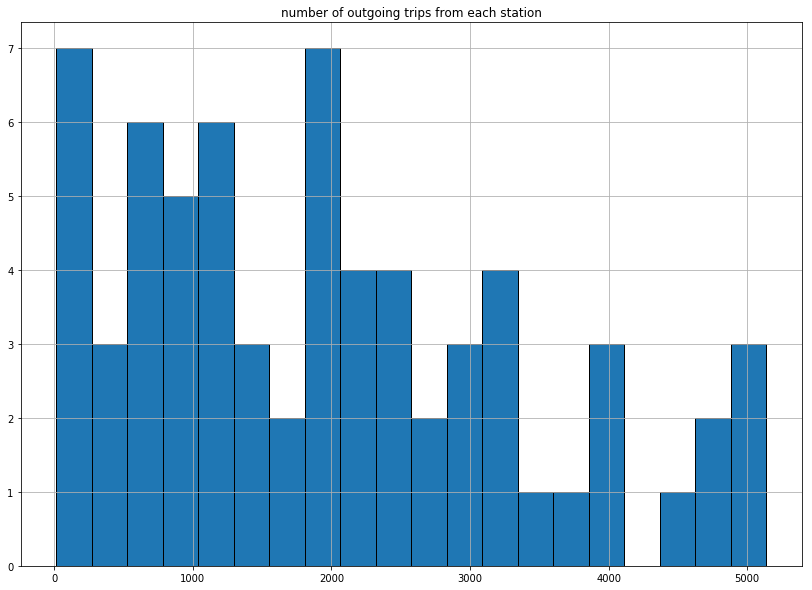

In [36]:
#Question 1:
'''
We took the Stating Station ID and counted the occurences after that we transformed them into dataframe
and created the plot
'''
bikes['Starting Station ID'].value_counts().to_frame('number of outgoing trips from each station') \
                                                                 .hist(bins=20,figsize=(14,10),edgecolor="black")

In [37]:
#Question 2
'''
As requested to plot the histogram for duration we have converted the values which are given in minutes to hours.
After that we have set the index as Count in order to have them on th y-axis and renamed index to duration 
so that our plot will make more sens.
'''
duration_hour=bikes['Duration'].value_counts().to_frame('Count').reset_index()
#From minutes to hours
duration_hour['index']=duration_hour['index'].apply(lambda x: x/60)

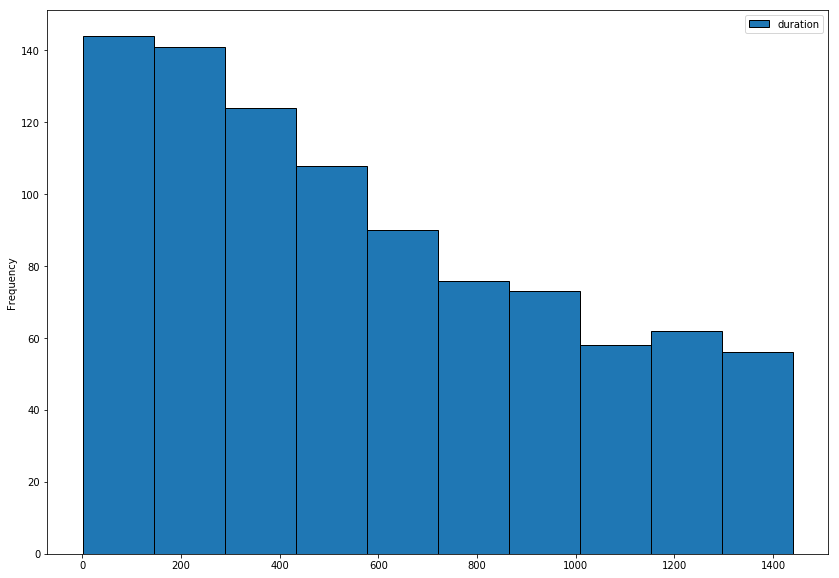

In [38]:
duration_hour.set_index('Count').rename(columns = {'index':'duration'}).plot(kind='hist',
                                                figsize=(14,10),edgecolor="black")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f652a9e1550>]],
      dtype=object)

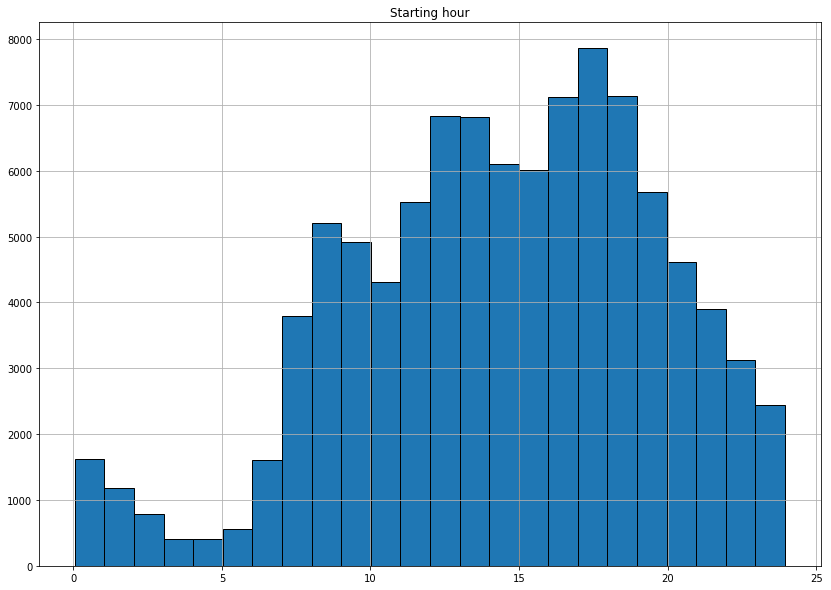

In [39]:
#Trip starting hour
'''
For the starting hour is a little bit tricky we have summed the hours and minutes and seconds with hour unit. 
After that in the plot we choosed 24 bins so that will have the discrite 1-hour interval.
'''
starting_hour=bikes["Start Time"].value_counts().to_frame('Count').reset_index()
starting_hour['index']=starting_hour["index"].apply(lambda x: x.hour+x.minute/60+x.second/3600)
starting_hour.set_index('Count').rename(columns = {'index':'Starting hour'})\
                                            .hist(bins=24,figsize=(14,10),edgecolor="black")

# Interpretation of the above histograms:
For the first plot "Duration": The local maxima is from 0 to 200, people prefere short tirps or rides. We can see
that the plot is decreasing with the growth of the duration. 

For the second one "Starting hour": We can observe that the maximum is at 17h, we can explain this also 
by people are done with their work journey and it's time to enjoy a bike ride :) 
Also at 12 during the break. We can also see that in early hours of the day there is small activity of bikes.


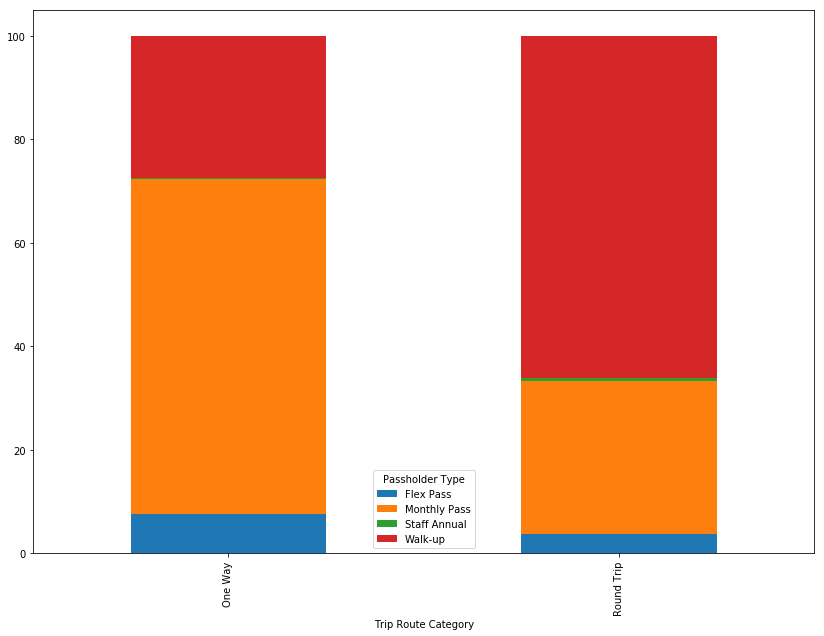

In [40]:
##3.For each trip route category, calculate the proportion of trips by passholder type 
##and present your results in a stacked bar chart with normalized height.
'''
We group by the route category and the passholder type, we keep only the bike ID columns to store the count.
After that we unstack the dataFrame and normalize it over 100%.
'''
bikes_cat=bikes.groupby(['Trip Route Category','Passholder Type'])['Bike ID'].count().unstack('Passholder Type')\
    .apply(lambda x: x / x.sum() * 100, axis=1)
bikes_cat.plot(kind='bar',stacked=True,figsize=(14,10))

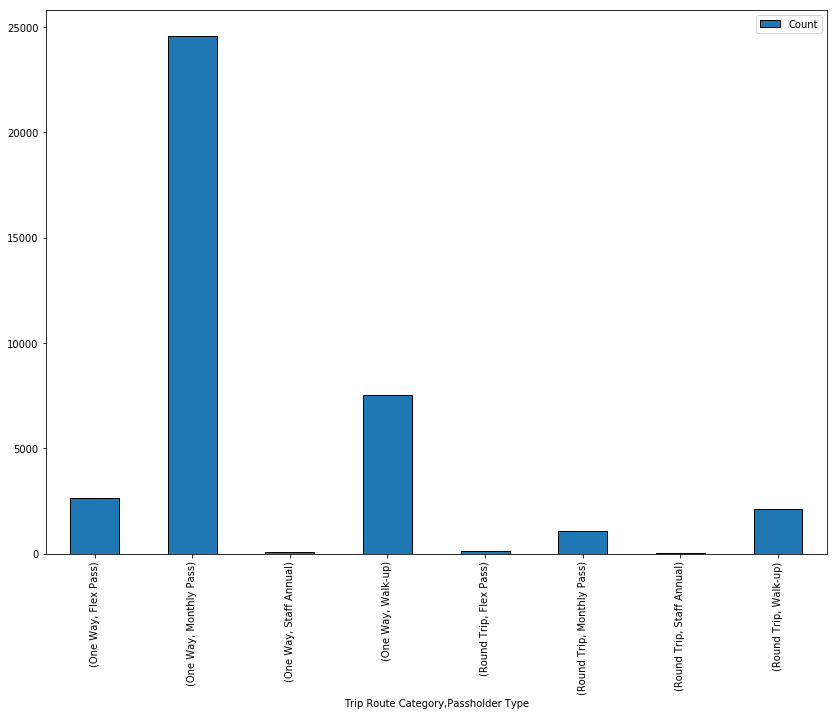

In [41]:
## Question 4:
'''
We keep only morning hours and we group by the Trip route category and the passholder type.
After doing the count we show the plot.
'''
starting_hour=pd.DataFrame(bikes, columns=['Start Time','Trip Route Category','Passholder Type'])
starting_hour['Start Time']=starting_hour["Start Time"].apply(lambda x: x.hour)
starting_hour=starting_hour[starting_hour["Start Time"]<12]
starting_hour.groupby(['Trip Route Category','Passholder Type']).count().\
        rename(columns={'Start Time':'Count'}).plot(kind='bar',figsize=(14,10),edgecolor="black")


staff annual category does not contain informations about the duration plan beaceause it was deleted
from the data (The mentionned this on the website).
For the monthly Pass, people prefer one Way trip route more than more than round Trip. We can also say 
that people with monthly pass do more one way trips.


In [42]:
#Questions 5:
'''
We first selected only the columns that we are interreseted in. After that we kept only the hour form the start
time column. 
After this we created a new dataframe to count the nomber of bikes out from the start hour. 
We have used the cumsum() methode to know the sum of all counts and to indentify where we are going to split 
the dataframe into two intervals.
'''
bikes_out_station=pd.DataFrame(bikes, columns=['Starting Station ID','Start Time','Passholder Type',
                                               'Trip Route Category','Trip ID'])
bikes_out_station['Start Time']=bikes_out_station['Start Time'].apply(lambda x: x.hour)
bikes_out_station.head()

,Starting Station ID,Start Time,Passholder Type,Trip Route Category,Trip ID
0,3014.0,4,Monthly Pass,Round Trip,1912818
1,3014.0,6,Monthly Pass,Round Trip,1919661
2,3016.0,10,Flex Pass,Round Trip,1933383
3,3016.0,10,Flex Pass,Round Trip,1944197
4,3032.0,12,Walk-up,Round Trip,1940317


__\* Briefly explain your approach for every query here \*__

In [43]:
out_station_count=bikes_out_station.groupby(['Start Time'])['Trip ID'].count().to_frame()

In [44]:
#creating the Culmulative Sum column
out_station_count['Cumulative Sum']=out_station_count.cumsum()
#finding the mean
mean=max(out_station_count['Cumulative Sum'])/2
#splitting the initial dataframe
interval_one=bikes_out_station[bikes_out_station['Start Time']<=max(out_station_count[\
                                                        out_station_count['Cumulative Sum']<=mean].index)]
interval_two=bikes_out_station[bikes_out_station['Start Time']>max(out_station_count[\
                                                        out_station_count['Cumulative Sum']<=mean].index)]


In [45]:
interval_one=interval_one.groupby(['Passholder Type','Trip Route Category'])['Trip ID'].count().to_frame()\
            .rename(columns = {'Trip ID':'count'})
interval_one

count
Passholder Type Trip Route Category       
Flex Pass       One Way               4034
                Round Trip             223
Monthly Pass    One Way              35148
                Round Trip            1776
Staff Annual    One Way                145
                Round Trip              55
Walk-up         One Way              13032
                Round Trip            3570

In [46]:
interval_two=interval_two.groupby(['Passholder Type','Trip Route Category'])['Trip ID'].count().to_frame()\
.rename(columns = {'Trip ID':'count'})
interval_two

count
Passholder Type Trip Route Category       
Flex Pass       One Way               5000
                Round Trip             260
Monthly Pass    One Way              42384
                Round Trip            1996
Staff Annual    One Way                154
                Round Trip              28
Walk-up         One Way              19745
                Round Trip            4877

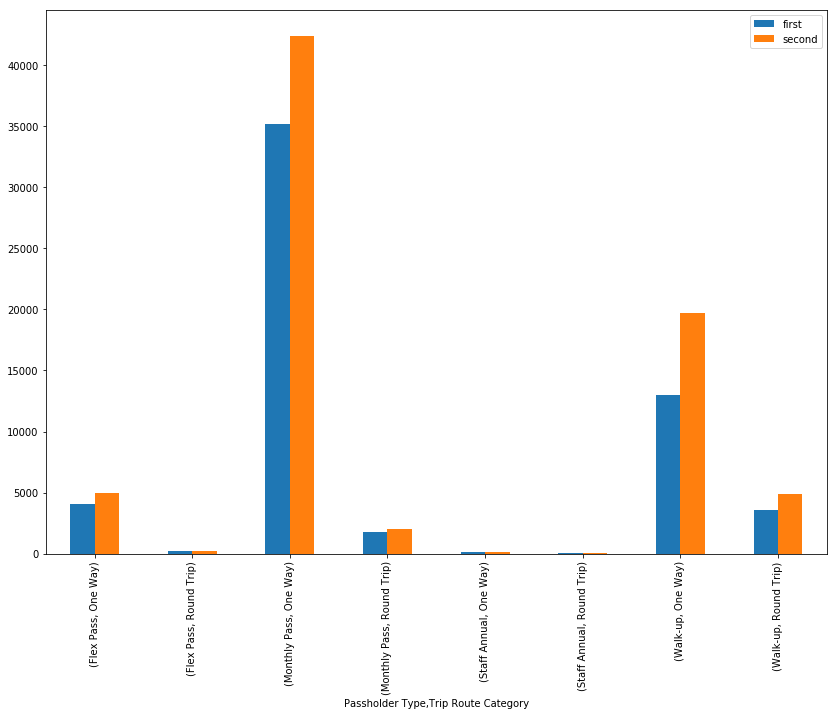

In [47]:
#in order to visualize the difference I have created a new dataframe which I called intervals which is the
#combination of the two split so that I can have a nice plot in order to have good conclusion :)
intervals=pd.DataFrame()
intervals['first']=interval_one['count']
intervals['second']=interval_two['count']
intervals=intervals[['first','second']]
intervals.plot(kind='bar',figsize=(14,10))


From the above plot we can see that the second interval is more important than the first one.
For the Monthly pass giving that the number of trips is unchanged, the company can make benefits by increasing 
the price for the second part and decreasing it for the first part equally. 
let's assume that the price is p and the raise is r
the count is m and n respectectivly for first and second, let's assume that n=m+ diff, with diff is the |n - m|
the new revenue is : m(p-r) + (m+diff)(p-r)=diff(p-r) which represent the bonus of the new schema.


In [48]:
#final Dataframe with unique non-composed index
interval_one=interval_one.apply(lambda x: x / x.sum() , axis=0)
interval_two=interval_two.apply(lambda x: x / x.sum() , axis=0)
intervals=pd.DataFrame()
intervals['first']=interval_one['count']
intervals['second']=interval_two['count']
intervals=intervals[['first','second']]

intervals.reset_index(inplace=True)
intervals['(Passholder Type,Trip Route Category)'] = list(zip(intervals['Passholder Type'],
                                                              intervals['Trip Route Category']))

intervals=pd.DataFrame(intervals,columns=['(Passholder Type,Trip Route Category)','first','second'])
intervals.set_index('(Passholder Type,Trip Route Category)')

,first,second
"(Passholder Type,Trip Route Category)",,
"(Flex Pass, One Way)",0.069572,0.067165
"(Flex Pass, Round Trip)",0.003846,0.003493
"(Monthly Pass, One Way)",0.606178,0.569341
"(Monthly Pass, Round Trip)",0.030630,0.026812
"(Staff Annual, One Way)",0.002501,0.002069
"(Staff Annual, Round Trip)",0.000949,0.000376
"(Walk-up, One Way)",0.224756,0.265233
"(Walk-up, Round Trip)",0.061570,0.065512
